## Imports

In [204]:
import json
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import RandomUniform, RandomNormal, HeNormal, GlorotUniform, Constant, Zeros
from keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2


dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search, random_search, tuning_search_top_configs
from training.solver import Solver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neural Networks
In this notebook we implement and test a custom (feed-forward) Neural Network w.r.t. the tasks at hand, i.e. the three MONK's problem and the CUP dataset. The employed optimizer is Stochastic Gradient Descent (SGD) with mini-batch.

Specifically:
- **get_nn_classifier(...)**: defines the NN classifier for the MONK's problems;
- **get_nn_regressor(...)**: defines the NN regressor for the CUP dataset.

## Settings

In [205]:
MODEL_NAME = 'NN-SGD'
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS = 5 # cross-validation

## Path

In [206]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [290]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Model

In [291]:
def get_nn_classifier(hparams):
    initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    
    model = Sequential([
        Dense(hparams['h_dim'], activation='tanh', input_shape=(17,), kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(hparams['reg']))
    ])
    
    optimizer = SGD(learning_rate=hparams['lr'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    
    model.hparams = hparams
    return model

## Training - Testing

In [ ]:
model_m1 = get_nn_classifier(hparams={'lr': 0.7, 'h_dim': 4, 'reg': 0.0})
solver = Solver(model_m1, x_dev_m1, y_dev_m1, x_test_m1, y_test_m1, target='loss')
solver.train(epochs=300, patience=None, batch_size=32)

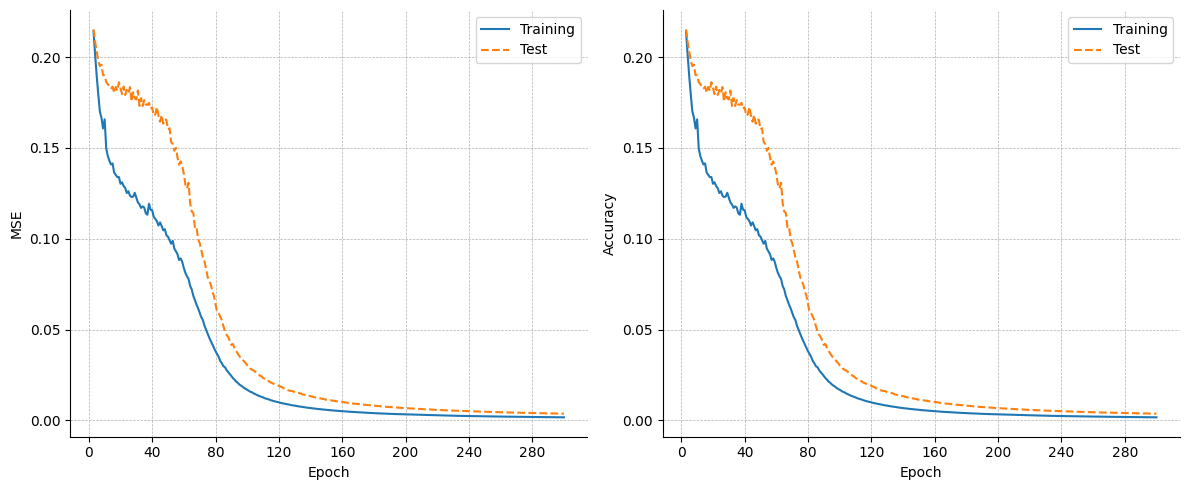

In [295]:
solver.plot_history(results_dir + '/MONK1/history', 'MSE', 'Accuracy')

In [296]:
print('-- DEVELOPMENT --')
acc_dev_m1, mse_dev_m1 = model_m1.evaluate(x_dev_m1, y_dev_m1)
print(f'Accuracy: {acc_dev_m1:.4f} - MSE: {mse_dev_m1:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Accuracy: 0.0016 - MSE: 1.0000


In [297]:
print('-- TEST --')
acc_test_m1, mse_test_m1 = model_m1.evaluate(x_test_m1, y_test_m1)
print(f'Accuracy: {acc_test_m1:.4f} - MSE: {mse_test_m1:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Accuracy: 0.0037 - MSE: 1.0000


## Store results

In [298]:
report_m1 = {
    'dev': {'accuracy': acc_dev_m1, 'mse': mse_dev_m1},
    'test': {'accuracy': acc_test_m1, 'mse': mse_test_m1}
}

store_monk_result(results_dir + '/MONK1/', model_m1.hparams, report_m1)

# MONK-2

In [302]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

## Training - Testing

In [ ]:
model_m2 = get_nn_classifier(hparams={'lr': 0.8, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m2, x_dev_m2, y_dev_m2, x_test_m2, y_test_m2, target='loss')
solver.train(epochs=300, patience=None, batch_size=64)

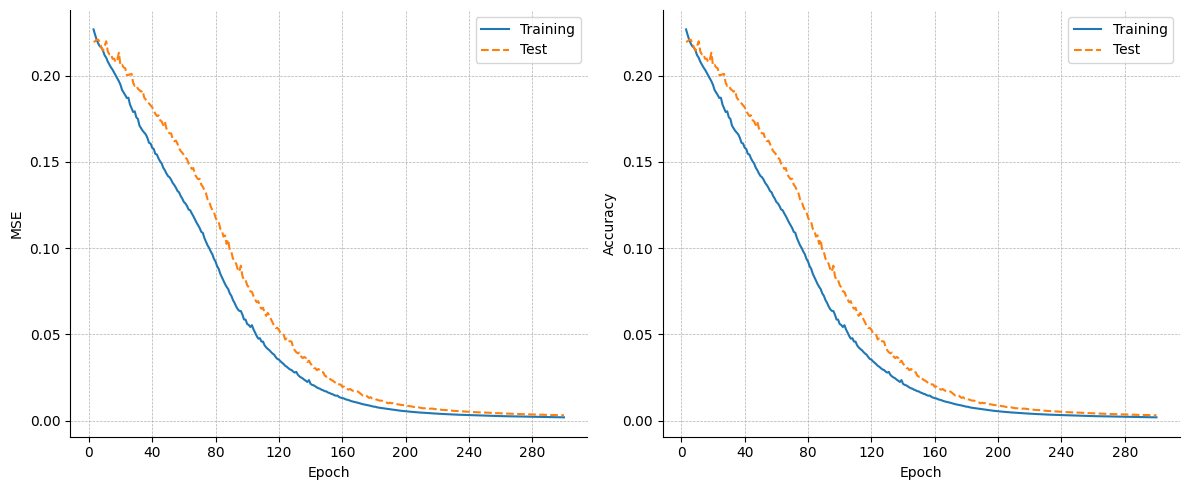

In [309]:
solver.plot_history(results_dir + '/MONK2/history','MSE', 'Accuracy')

In [310]:
print('-- DEVELOPMENT --')
acc_dev_m2, mse_dev_m2 = model_m2.evaluate(x_dev_m2, y_dev_m2)
print(f'Accuracy: {acc_dev_m2:.4f} - MSE: {mse_dev_m2:.4f}')

-- DEVELOPMENT --
6/6 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Accuracy: 0.0019 - MSE: 1.0000


In [311]:
print('-- TEST --')
acc_test_m2, mse_test_m2 = model_m2.evaluate(x_test_m2, y_test_m2)
print(f'Accuracy: {acc_test_m2:.4f} - MSE: {mse_test_m2:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Accuracy: 0.0031 - MSE: 1.0000


## Store results

In [312]:
report_m2 = {
    'dev': {'accuracy': acc_dev_m2, 'mse': mse_dev_m2},
    'test': {'accuracy': acc_test_m2, 'mse': mse_test_m2}
}

store_monk_result(results_dir + '/MONK2/', model_m2.hparams, report_m2)

# MONK-3 (no regularization)

In [ ]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

## Training - Testing

In [ ]:
model_m3 = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m3, x_dev_m3, y_dev_m3, x_test_m3, y_test_m3, target='loss')
solver.train(epochs=300, patience=None, batch_size=128)

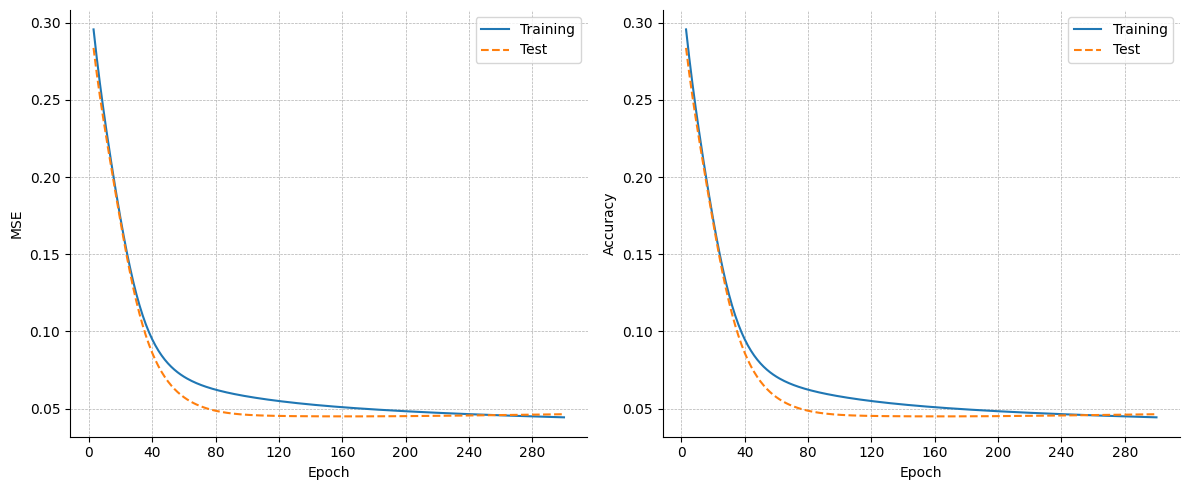

In [321]:
solver.plot_history(results_dir + '/MONK3/history','MSE', 'Accuracy')

In [322]:
print('-- DEVELOPMENT --')
acc_dev_m3, mse_dev_m3 = model_m3.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3:.4f} - MSE: {mse_dev_m3:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 1ms/step - loss: 0.0443 - accuracy: 0.9508
Accuracy: 0.0443 - MSE: 0.9508


In [323]:
print('-- TEST --')
acc_test_m3, mse_test_m3 = model_m3.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3:.4f} - MSE: {mse_test_m3:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.9537
Accuracy: 0.0463 - MSE: 0.9537


## Store results

In [324]:
report_m3 = {
    'dev': {'accuracy': acc_dev_m3, 'mse': mse_dev_m3},
    'test': {'accuracy': acc_test_m3, 'mse': mse_test_m3}
}

store_monk_result(results_dir + '/MONK3/', model_m3.hparams, report_m3)

# MONK-3 (with regularization)
MONK3 when setting some regularization value.

## Training - Testing

In [ ]:
model_m3_reg = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0.001})
solver = Solver(model_m3_reg, x_dev_m3, y_dev_m3,  x_test_m3, y_test_m3, target='accuracy')
solver.train(epochs=300, patience=None, batch_size=128)

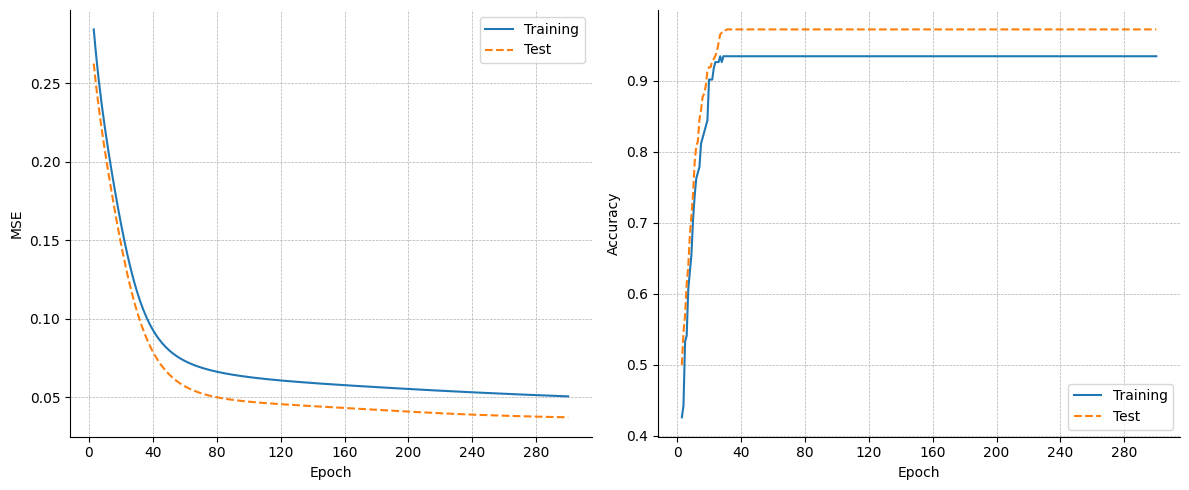

In [316]:
solver.plot_history(results_dir + '/MONK3-reg/history','MSE', 'Accuracy')

In [317]:
print('-- DEVELOPMENT --')
acc_dev_m3_reg, mse_dev_m3_reg = model_m3_reg.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3_reg:.4f} - MSE: {mse_dev_m3_reg:.4f}')

-- DEVELOPMENT --
4/4 [==============================] - 0s 1ms/step - loss: 0.0504 - accuracy: 0.9344
Accuracy: 0.0504 - MSE: 0.9344


In [318]:
print('-- TEST --')
acc_test_m3_reg, mse_test_m3_reg = model_m3_reg.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3_reg:.4f} - MSE: {mse_test_m3_reg:.4f}')

-- TEST --
14/14 [==============================] - 0s 846us/step - loss: 0.0371 - accuracy: 0.9722
Accuracy: 0.0371 - MSE: 0.9722


## Store results

In [319]:
report_m3_reg = {
    'dev': {'accuracy': acc_dev_m3_reg, 'mse': mse_dev_m3_reg},
    'test': {'accuracy': acc_test_m3_reg, 'mse': mse_test_m3_reg}
}

store_monk_result(results_dir + '/MONK3-reg/', model_m3_reg.hparams, report_m3_reg)

# CUP

In [325]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [326]:
def mean_euclidean_error(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Utility function to compute the Mean Euclidean Error (MEE) between 
    true and predicted values for a tensorflow model. 
    Return the MEE score as a tensor.

    Required arguments:
    - y_true: array containing true values (ground truth).
    - y_pred: array containing predicted values.
    """
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)))

## Train-Val + Internal Test Split 
First, the development data is split between training and internal test ($90-10$). Then, the training data is further split between training and validation so that the final split is exactly $80-10-10$, for training, validation and internal test sets.

In [327]:
# Split dev data into train - internal test
x_train_cup, x_internal_test_cup, y_train_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, 
    y_dev_cup, 
    test_size=INTERNAL_TEST_SPLIT, 
    random_state=128
)

# NN-SGD (mb)

In [328]:
def get_nn_sgd_regressor(hparams):
    if hparams['activation'] == 'tanh':
        initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
        bias_initializer = Zeros()
    elif hparams['activation'] == 'ReLU':
        initializer = HeNormal(seed=RANDOM_STATE) # He (Kaiming)
        bias_initializer = Constant(0.1)
        
    reg = l2(hparams['reg'])
        
    model = Sequential()
    model.add(Dense(
        hparams['h_dim'], 
        activation=hparams['activation'], 
        input_shape=(10,), 
        kernel_regularizer=l2(hparams['reg']),
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    h_dim = hparams['h_dim']
    for i in range(hparams['n_layers'] - 1):
        model.add(
            Dense(
                h_dim, 
                activation=hparams['activation'],
                kernel_regularizer=l2(hparams['reg']),
                kernel_initializer=initializer,
                bias_initializer=bias_initializer))
        h_dim //= 2
        
    model.add(Dense(
        3, 
        activation='linear', 
        kernel_regularizer=l2(hparams['reg']), 
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    optimizer = SGD(learning_rate=hparams['lr'], momentum=hparams['momentum'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[mean_euclidean_error])
    return model

## Hyper-parameters Tuning
A common approach is to start with a coarse search across a wide range of values to find promising sub-ranges of our parameter space. Then, you would zoom into these ranges and perform another search to fine-tune the configurations.

Here, we proceed as follows:
1. (coarse) Grid-search across a wide range of hyper-paramaters and values;
2. (fine-tune) Random-search into zoomed intervals w.r.t. best configuration found by grid-search.

### Grid Search

In [ ]:
grid_search_spaces_cup = {
    'lr': [0.01, 0.001, 0.0001],
    'n_layers': [2, 3],
    'h_dim': [32, 64, 128],
    'activation': ['tanh'],
    'reg': [0.01, 0.001],
    'momentum': [0.9],
    'batch_size': [32, 64, 128],
}

In [ ]:
# Grid search (coarse)
best_model_coarse, best_config_coarse, results_coarse = grid_search(
    get_nn_sgd_regressor, 
    x_train_cup,
    y_train_cup,
    grid_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    EPOCHS=800, 
    PATIENCE=50
)

### Random Search

In [ ]:
# set new intervals for fine-tune random search
lr = best_config_coarse['lr']
n_layers = best_config_coarse['n_layers']
h_dim = best_config_coarse['h_dim']
activation = best_config_coarse['activation']
reg = best_config_coarse['reg']
momentum = best_config_coarse['momentum']
batch_size = best_config_coarse['batch_size']

In [ ]:
"""
epsilon = 0.2
random_search_spaces_cup = {
    'lr': ([10 ** (np.log10(lr) - epsilon), 10 ** (np.log10(lr) + epsilon)], 'float'),
    'n_layers': ([n_layers], 'item'),
    'h_dim': ([h_dim - 20, h_dim + 20], 'item'),
    'activation': ([activation], 'item'),
    'reg': ([10 ** (np.log10(reg) - epsilon), 10 ** (np.log10(reg) + epsilon)], 'float'),
    'momentum': ([10 ** (np.log10(momentum) - epsilon), 10 ** (np.log10(momentum) + epsilon)], 'float'),
    'batch_size': ([batch_size], 'item'),
}
"""

random_search_spaces_cup = {
    'lr': ([0.01, 0.004], 'float'),
    'n_layers': ([2, 3], 'item'),
    'h_dim': ([64, 80, 100], 'item'),
    'activation': (['tanh'], 'item'),
    'reg': ([0.001], 'item'),
    'momentum': ([0.93, 0.98], 'float'),
    'batch_size': ([32], 'item'),
}

In [ ]:
# Random search (fine-tune)
best_model_finetune, best_config_finetune, results_finetune = random_search(
    get_nn_sgd_regressor, 
    x_train_cup,
    y_train_cup,
    random_search_spaces_cup, 
    target='mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    NUM_SEARCH=20,
    EPOCHS=800, 
    PATIENCE=50
)

### Save tuning results

In [ ]:
mee_coarse = best_config_coarse['mean_euclidean_error']
mee_finetune = best_config_finetune['mean_euclidean_error']

best_config_cup = best_config_finetune if mee_finetune < mee_coarse else best_config_coarse

In [ ]:
# Store grid-search
best_config_coarse['n_layers'] = int(best_config_coarse['n_layers'])
best_config_coarse['h_dim'] = int(best_config_coarse['h_dim'])
best_config_coarse['batch_size'] = int(best_config_coarse['batch_size'])
with open(results_dir + '/CUP/grid_search.json', 'w') as outf:
    json.dump(best_config_coarse, outf, indent=4)
    
# Store random-search
best_config_finetune['n_layers'] = int(best_config_finetune['n_layers'])
best_config_finetune['h_dim'] = int(best_config_finetune['h_dim'])
best_config_finetune['batch_size'] = int(best_config_finetune['batch_size'])
with open(results_dir + '/CUP/random_search.json', 'w') as outf:
    json.dump(best_config_finetune, outf, indent=4)

## Training

In [ ]:
best_config_cup = {
    'lr': 0.00035,
    'h_dim': 100,
    'n_layers': 3,
    'activation': 'tanh',
    'reg': 0.001,
    'momentum': 0.95, 
    'batch_size': 32,
}

model_nn_cup = get_nn_sgd_regressor(best_config_cup)
solver = Solver(model_nn_cup, x_train_cup, y_train_cup, x_internal_test_cup, y_internal_test_cup, target='mean_euclidean_error')
solver.train(epochs=1500, patience=100)

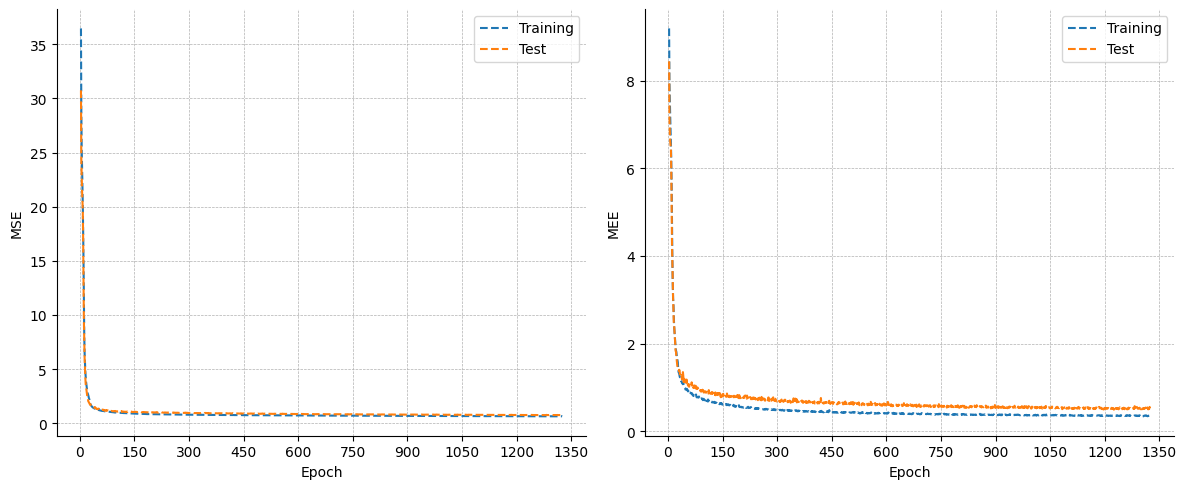

In [84]:
solver.plot_history(results_dir + '/CUP/history')

In [ ]:
print('-- TRAINING --')
loss_train_cup, mee_train_cup = model_nn_cup.evaluate(x_train_cup, y_train_cup)
print(f'Loss (MSE): {loss_train_cup:.4f} -  MEE: {mee_train_cup:.4f}')

In [ ]:
print('-- INTERNAL TEST --')
loss_internal_test_cup, mee_internal_test_cup = model_nn_cup.evaluate(x_internal_test_cup, y_internal_test_cup)
print(f'Loss (MSE): {loss_internal_test_cup:.4f} -  MEE: {mee_internal_test_cup:.4f}')

## Blind Test Predictions

In [ ]:
# Blind test set predictions
nn_preds_cup = model_nn_cup.predict(x_test_cup)

## Store Result

In [88]:
report_nn = {
    'train': {'mse': loss_train_cup, 'mee': mee_train_cup},
    'internal_test': {'mse': loss_internal_test_cup, 'mee': mee_internal_test_cup}
}

store_cup_result(results_dir + '/CUP/', best_config_cup, report_nn, nn_preds_cup)